<a href="https://colab.research.google.com/github/Alexis-Georganopoulos/Sentiment_Classifier/blob/main/RNN_YELP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Yelp Reviews Using RNN's

In [ ]:
# core libraries
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# string manipulation for ml
import sys
import string
from collections import Counter

# boilerplate and visualisation
from tqdm.notebook import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
vocab = {}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Vocabulary Function Definitions

In [ ]:
# We build the vocabulary based on the words in a given review. 
# First initializes the vocabulary, then count the occurrence of each word in the review column

def initializeVocabulary():
    unkToken = '<UNK>'
    vocab['t_2_i'] = {}
    vocab['i_2_t'] = {}
    idx = addToken(unkToken)
    vocab['addUnk'] = True
    vocab['unkToken'] = unkToken
    vocab['unkTokenIdx'] = idx

#### token manipulation ####
def addToken(token):
  if token in vocab['t_2_i']:
      idx = vocab['t_2_i'][token]
  else:
      idx = len(vocab['t_2_i'])
      vocab['t_2_i'][token] = idx
      vocab['i_2_t'][idx] = token
  return idx

def addManyTokens(tokens):
  idxes = [addToken(token) for token in tokens]
  return idxes

def lookUpToken(token):
    if vocab['unkTokenIdx'] >= 0:
        return vocab['t_2_i'].get(token,vocab['unkTokenIdx'])
    else:
        return vocab['t_2_i'][token]

def lookUpIndex(idx):
    if idx not in vocab['i_2_t']:
        raise KeyError("the index (%d) is not there" % idx)
    return vocab['i_2_t'][idx]
############################

# Constructs vocabulary
def vocabularyFromDataFrame(df,cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    for r in df.review:
        for word in r.split(" "):
            if word not in string.punctuation:
                wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

##Import Dataset

In [ ]:
# load dataset
drive.mount('/content/drive')
df = pd.read_csv(r'/content/drive/MyDrive/MyGithub/Sentiment_Classifier/reviews.csv')

Mounted at /content/drive


In [ ]:
vocabularyFromDataFrame(df,cutoff=25)
# basic verification
print(lookUpToken('this'))
print(lookUpIndex(128))
print(len(vocab['t_2_i']))

128
this
8945


In [ ]:
# Used to convert a review text into a one-hot encoded 
# matrix representation that can be inputted into the RNN model

def vectorize(review):
    isFirst = True
    for token in review.split(" "):
        if token not in string.punctuation:
            oneHot = np.zeros((len(vocab['t_2_i']),1))
            oneHot[lookUpToken(token)] = 1
            if isFirst:
                xF = oneHot
                isFirst = False
            else:
                xF = np.hstack((xF,oneHot))
    return xF

In [ ]:
# basic verification
print(df['review'][1])
xF = vectorize(df['review'][1])
print(xF.shape)

 hours , minutes total time for an extremely simple physical . stay away unless you have hours to waste ! ! ! 
(8945, 17)


In [ ]:
# basic inspection

print(df.shape)
df.sample(frac = 1).head(10)

(56000, 2)


,rating,review
39837,positive,these guys have a good thing going and they wo...
23466,negative,"wow mimi s . . . n nyou sadden me , even with ..."
40265,positive,just got back from a trip to the burgh and of ...
35701,positive,"i have to say , as far new age bookstores go ,..."
4394,negative,this is another place that is commonly suggest...
12940,negative,this place has some wonderful sandwiches . i w...
37629,positive,pretty much upon entry i was congratulated for...
17355,negative,not a fan at all . i was looking for a late ni...
43587,positive,"the location is a bit tucked in the corner , a..."
13383,negative,i would do my own nails before going back ther...


## Split the Data

In [ ]:
# split the data, and reduce the size for computational limitations

train, test = train_test_split(df, test_size=0.4)
div = 2600 # div = 1 --> train + test = 56,000 dataponts
train = train.iloc[:int(len(train)/div)]
test = test.iloc[:int(len(test)/div)]

print("train = %d , test = %d"%(len(train), len(test))) 


train = 12 , test = 8


In [ ]:
#implementing the vocabulary for the training set

vocabularyFromDataFrame(train,cutoff=0)
#sanity check
print(len(vocab['t_2_i']))

456


## RNN Architecture and Propagation Function Definitions




In [ ]:
# Defining the architecture of the RNN
numFeatures = len(vocab['t_2_i'])
hiddenUnits = 10

h0 = (torch.tensor(np.zeros((hiddenUnits,1))))
Wx = (torch.tensor(np.random.uniform(0,1,(hiddenUnits,numFeatures)),requires_grad=True))
Wh = torch.tensor(np.random.uniform(0,1,(hiddenUnits,hiddenUnits)),requires_grad=True)
Wy = torch.tensor(np.random.uniform(0,1,(1,hiddenUnits)),requires_grad=True)

In [ ]:
# Defining the forward propagation

# For single vocabulary
def stepForward(xt,Wx,Wh,Wy,prevMemory):
    x_frd = torch.matmul(Wx,(torch.from_numpy(xt[:,np.newaxis])))
    h_frd = torch.matmul(Wh,prevMemory)
    ht = torch.tanh(x_frd+h_frd)
    yt_hat = torch.sigmoid(torch.matmul(Wy,ht))
    return ht,yt_hat

# For single review
def fullForwardRNN(X,Wx,Wh,Wy,prevMemory):
    y_hat = 0
    for t in range(X.shape[1]):
        ht,yt_hat = stepForward(X[:,t],Wx,Wh,Wy,prevMemory)
        prevMemory = ht
        y_hat = yt_hat
    return y_hat

# Across all reviews
def computeForward(df, Wx, Wh, Wy, prevMemory):
  y = []
  y_hat = []
  for rv,rt in zip(df['review'],df['rating']):
    X = vectorize(rv)
    yi_hat = fullForwardRNN(X,Wx,Wh,Wy,prevMemory)
    yi = 0
    if rt == 'positive':
        yi = 1
    y.append(yi)
    y_hat.append(yi_hat)
  return y,y_hat  

In [ ]:
# Defining our loss and accuracy functions

# Only this is used during backpropagation
# BCE loss
def computeLoss(y,y_hat):
    loss = 0
    for yi,yi_hat in zip(y,y_hat):
        if yi == 1:
            loss += -torch.log2(yi_hat)
        else:
            loss += -torch.log2(1-yi_hat)
    return loss/len(y)

def computeAccuracy(y,y_hat):
  y_hat_list = torch.cat(y_hat).detach().numpy().flatten().tolist()
  y_hat_list = [1 if i > 0.5 else 0 for i in y_hat_list]
  accuracy = [1 if i == j else 0 for i,j in zip(y,y_hat_list)]
  accuracy = sum(accuracy)/len(y)
  return accuracy

In [ ]:
# Defining the parameter update rules

def updateParams(Wx,Wh,Wy,dWx,dWh,dWy,lr):
    with torch.no_grad():
        Wx -= lr*dWx
        Wh -= lr*dWh
        Wy -= lr*dWy
    return Wx,Wh,Wy

##Function that Trains the Model

In [ ]:
# Primary network training loop
# batch size = sample size for all epochs

def trainRNN(train_df,Wx,Wh,Wy,prevMemory,lr,nepoch,val_df):
    losses = []
    validation_losses = []
    training_accuracy = []
    validation_accuracy = []
    for epoch in tqdm(range(nepoch)):
        y,y_hat, y_val, y_hat_val = [],[],[],[]

        y, y_hat = computeForward(train_df, Wx, Wh, Wy, prevMemory)
        y_val, y_hat_val = computeForward(val_df, Wx, Wh, Wy, prevMemory)

        loss = computeLoss(y,y_hat)
        loss.backward()
        losses.append(loss)
        training_accuracy.append(computeAccuracy(y,y_hat))

        validation_accuracy.append(computeAccuracy(y_val, y_hat_val))
        validation_losses.append(computeLoss(y_val,y_hat_val))
    
        sys.stdout.flush()
        dWx = Wx.grad.data
        dWh = Wh.grad.data
        dWy = Wy.grad.data
        Wx,Wh,Wy = updateParams(Wx,Wh,Wy,dWx,dWh,dWy,lr)
        Wx.grad.data.zero_()
        Wh.grad.data.zero_()
        Wy.grad.data.zero_()

    #sanity check
    print(y)
    print(torch.cat(y_hat).detach().numpy().flatten().tolist())
    return Wx,Wh,Wy,losses,validation_losses, training_accuracy, validation_accuracy

## Train the Model and Observe the Results

In [ ]:
#Training the model
Wx,Wh,Wy,t_loss,val_loss, t_acc,val_acc = trainRNN(train_df=train,Wx=Wx,Wh=Wh,Wy=Wy,prevMemory=h0,lr=0.01,nepoch=150, val_df=test)


  0%|          | 0/150 [00:00<?, ?it/s]

[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]
[0.5222440236099141, 0.5222423933262647, 0.5222341133497155, 0.5222385851822844, 0.5222415062271882, 0.5222492760305637, 0.5222456688016891, 0.5222427500630801, 0.5222399635338838, 0.5222360129132814, 0.5222448204522516, 0.5222414563123968]


In [ ]:
# Peek for sanity check
r = train['review'].iloc[6]
y = train['rating'].iloc[6]

X = vectorize(r)
y_hat = fullForwardRNN(X,Wx,Wh,Wy,h0)

print(y_hat.detach().numpy().flatten().tolist())# y_hat<0.5 = negative, else positive prediction
print(y)

[0.5214454573383261]
negative


In [ ]:
# Convenience
t_loss = torch.cat(t_loss).detach().numpy().flatten().tolist()
val_loss = torch.cat(val_loss).detach().numpy().flatten().tolist()

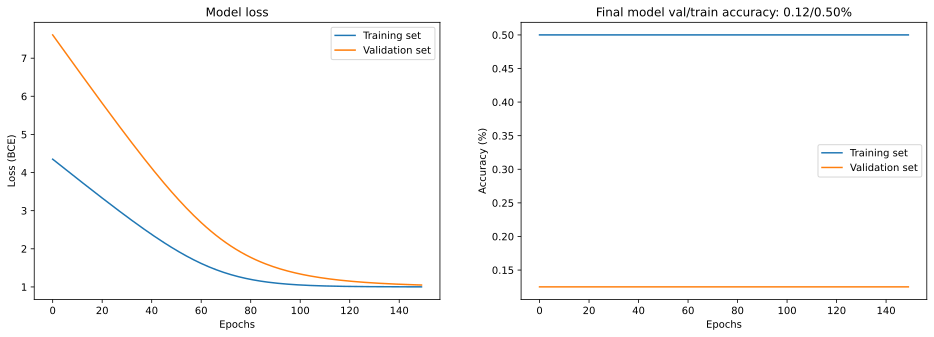

In [ ]:
# Visualising results

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(t_loss,label='Training set')
ax[0].plot(val_loss,label='Validation set')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (BCE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(t_acc,label='Training set')
ax[1].plot(val_acc,label='Validation set')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model val/train accuracy: {val_acc[-1]:.2f}/{t_acc[-1]:.2f}%')
ax[1].legend()

plt.show()